# Gaussian analysis for similarity scores

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import stat
import pickle
from bs4 import BeautifulSoup

# Model for Gaussian Mixture
from sklearn.mixture import GaussianMixture
%pip install astroML | grep -v 'already satisfied'
%pip install pymc3 | grep -v 'already satisfied'

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Load data

In [28]:
# Load the data to analyze
with open('./data/similarities.pickle', 'rb') as handle:
    sim = pickle.load(handle)

In [46]:
def plot_kde(simdic):
    '''
    Function that takes as input a similarities dictionnary
    Plot the histogram and kde estimation of the similarities
    '''
    for tick, df in sim.items():
        fig, ax = plt.subplots(figsize = (10, 6))
        sns.histplot(data = df, x = 'tfidf_cosine_sim', bins = 20, alpha = 0.4, ax = ax)
        sns.kdeplot(data = df, x = 'tfidf_cosine_sim', ax = ax, color = 'green')
        ax.set_title('{} cosine similarities distribution'.format(tick))
        plt.show()

## Define helper function that finds roots of a function

In [31]:
def roots(fct):
    '''
    Function that tries to find the roots of a function between 0 and 1
    '''
    X = np.linspace(0, 1, 1000)
    sign = True if fct(X[0]) > 0 else False
    candidates = []
    
    for x in X:
        if fct(x) > 0:
            new_sign = True
        elif fct(x) <= 0:
            new_sign = False

        if new_sign != sign:
            sign = new_sign
            candidates.append(x)
            
    return(candidates)

### Apply Gaussian Mixtures to our data

In [48]:
class gaussian_analysis:
    '''
    Class that performs Gaussian classification of changers / non-changers
    '''
    def __init__(self, simdic, similarity = 'tfidf_cosine_sim'):
        self.simdic = simdic
        self.similarity = similarity
        
        
    def gaussian_classifier(self):
        '''
        Function that takes as input a dictionnary of similarities dataframes
        Returns the best Gaussian fit on this data, allowing for classification
        '''
        # Best model and number of parameters for each company
        bestmodel = {}

        for tick, sim in self.simdic.items():
            # Put the data in correct shape
            simdata = list(sim[self.similarity])
            simarr = np.array([[x] for x in simdata])

            if len(simarr) <= 1:
                bestmodel[tick] = [0, None, None, None]
                continue

            # fit two models: first with one Gaussian component, second with 2 gaussian components
            models = []
            for i in range(1,3):
                models.append(GaussianMixture(i).fit(simarr))

            # Calculate AIC and BIC for both models
            AIC = [m.aic(simarr) for m in models]
            BIC = [m.bic(simarr) for m in models]

            # Select the best model
            M_best = models[np.argmin(AIC)]
            comp_best = np.argmin(AIC) + 1

            # Calculate probabilities for each point to belong to distributions
            x = np.linspace(0, 1, 1000).reshape(-1, 1)
            pred_prob = M_best.predict_proba(x).T

            # Add the best model to the final dic
            bestmodel[tick] = [comp_best, M_best, pred_prob]
            # bestmodel[tick] = [comp_best, M_best, fct, pred_prob]
        
        return(bestmodel)
    
        
    def plot_gaussians(self):
        '''
        Function that plots Gaussian individual fits of similarities
        '''
        # Call the Gaussian CLassifier function
        gaussclf = self.gaussian_classifier()
            
        # Define x-axis
        x = np.linspace(0, 1, 1000).reshape(-1, 1)
            
        for tick, gauss in gaussclf.items():
            # If no Gaussian estimation
            if gauss[0] == 0:
                continue
                
            # Extract best fit
            M_best = gauss[1]
                
            # Create figure
            fig = plt.figure(figsize = (10,6))
            ax = fig.add_subplot(111)

            # Compute probabilities
            logprob = M_best.score_samples(x)
            responsibilities = M_best.predict_proba(x)
            pdf = np.exp(logprob)
            pdf_individual = responsibilities * pdf[:, np.newaxis]

            # Plot figure
            ax.plot(x, pdf_individual)
            ax.set_title('{} Gaussian Mixture individual estimation'.format(tick))
            plt.show()
            
        
    def plot_pdf(self):
        '''
        Function that plot the aggregated pdf of the Gaussian fit of similarities
        ''' 
        # Call the Gaussian CLassifier function
        gaussclf = self.gaussian_classifier()
            
        # Define x-axis
        x = np.linspace(0, 1, 1000).reshape(-1, 1)
            
        for tick, gauss in gaussclf.items():
            # If no Gaussian estimation
            if gauss[0] == 0:
                continue
            
            # Extract best fit
            M_best = gauss[1]
                
            # Create figure
            fig = plt.figure(figsize = (10,6))
            ax = fig.add_subplot(111)

            # Compute pdf
            logprob = M_best.score_samples(x)
            pdf = np.exp(logprob)

            # Plot x vs pdf
            ax.plot(x, pdf, '-o')
            ax.set_title('{} reporting similarities ditribution'.format(tick))
            plt.show()
                
                
    def threshold_estimation(self, save = True):
        '''
        Function that takes as input a dictionnary generated by the gaussian_classifier function
        Returns an estimated threshold value to seperate changers and non changers
        '''
        # Call the gaussian classifier function
        gaussclf = self.gaussian_classifier()
            
        thresh_dic = {}
        estimator1 = lambda x, m_best: m_best.predict_proba(x).T[0]
        estimator2 = lambda x, m_best: m_best.predict_proba(x).T[1]

        for tick, gauss in gaussclf.items():
            nb_comp = gauss[0]

            if nb_comp == 0:
                # Not enough data to estimate a Gaussian Distribution
                thresh_dic[tick] = 0.75

            elif nb_comp == 1:
                # One Gaussian estimator
                mbest = gauss[1]
                mean = mbest.means_[0]
                std = np.sqrt(np.trace(mbest.covariances_[0]))
                thresh_dic[tick] = (mean - std)[0] # Rule of thumb! Check for a more accurate value, maybe based on how far from Guassian expectation

            elif nb_comp == 2:
                # Two Gaussian estimators
                # Define the pdf difference function, for which we'll try to find the roots afterwards
                mbest = gauss[1]
                pdf_diff = lambda x, m_best: estimator1(x, m_best) - estimator2(x, m_best)
                pdf_diff_2 = lambda x, m_best: pdf_diff([[x]], m_best)[0] if (type(x) is np.float64 or type(x) is np.int64) else pdf_diff(x, m_best)

                # Find the roots of the function
                rts = roots(lambda y: pdf_diff_2(y, mbest))

                # Add the result to the final dic
                thresh_dic[tick] = float(rts[-1])

            else:
                raise Exception('Too many Gaussian estimators! Check Gaussian generation process...')
         
        if save:
            # Save the thresholds as pickle file
            save_path = './data/thresholds.pickle'
            with open(save_path, 'wb') as handle:
                pickle.dump(thresh_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return(thresh_dic)
    
    def threshold_estimation_2(self, save = True):
        '''
        Function that defines a fixed threshold for all companies to 
        '''
        # Call the gaussian classifier function
        gaussclf = self.gaussian_classifier()
        thresh_dic = {tick: 0.8 for tick in gaussclf.keys()}
        
        if save:
            # Save the thresholds as pickle file
            save_path = './data/thresholds_fixed.pickle'
            with open(save_path, 'wb') as handle:
                pickle.dump(thresh_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        return(thresh_dic)

In [49]:
# Create the gaussian analysis object
gauss_ana = gaussian_analysis(sim)

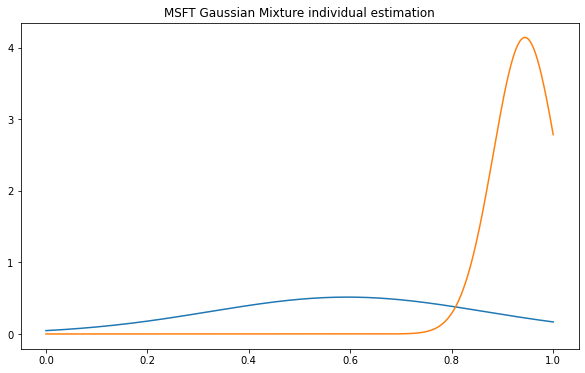

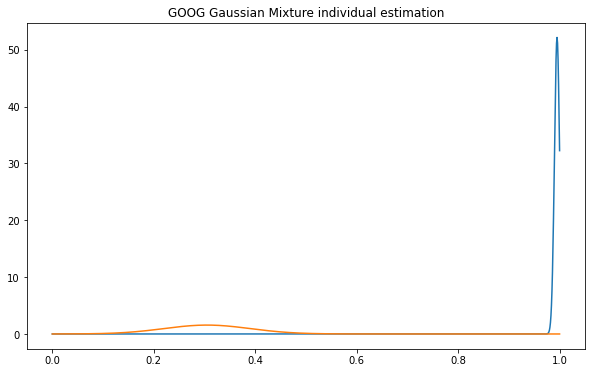

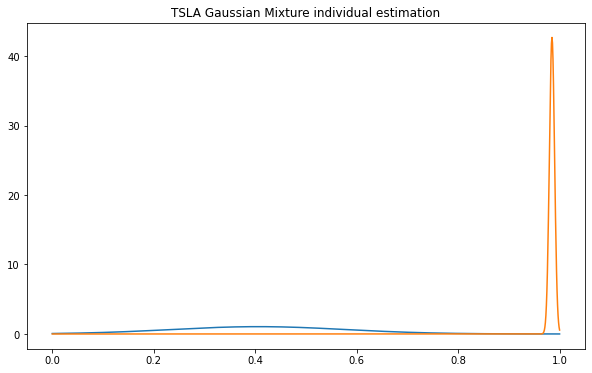

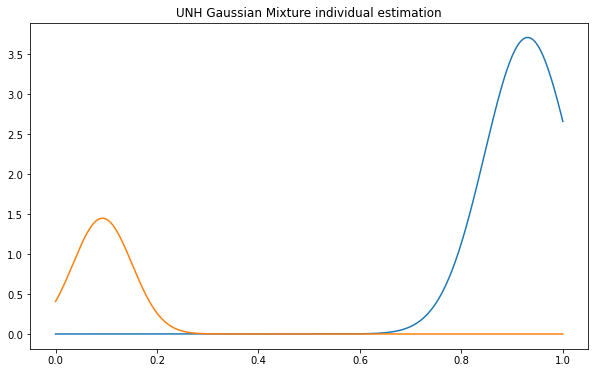

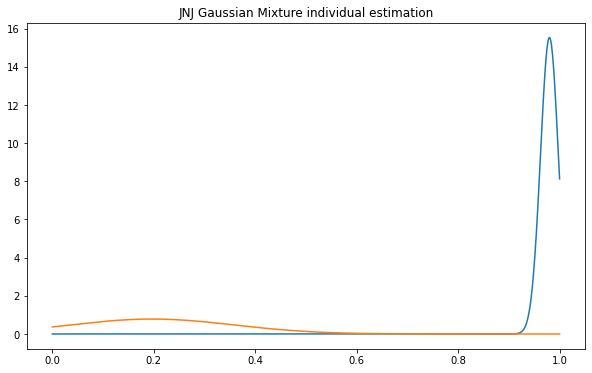

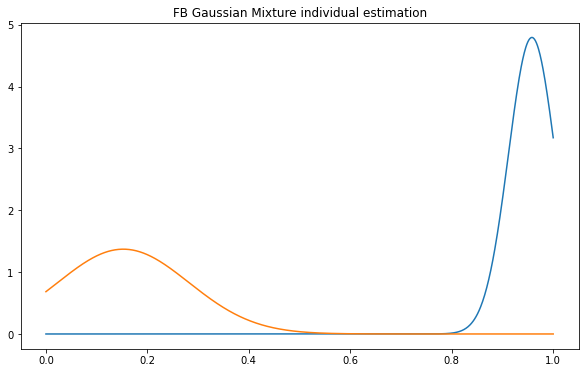

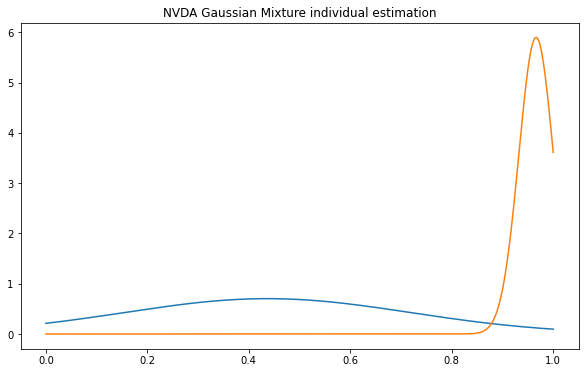

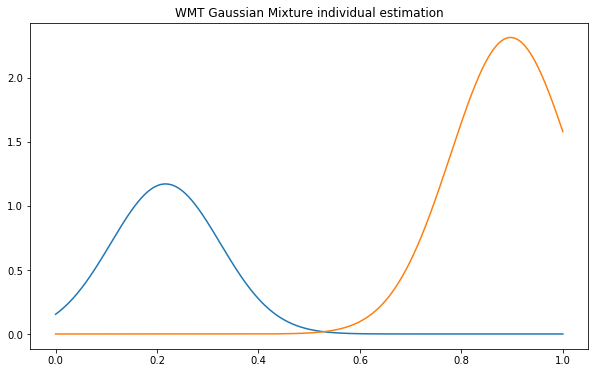

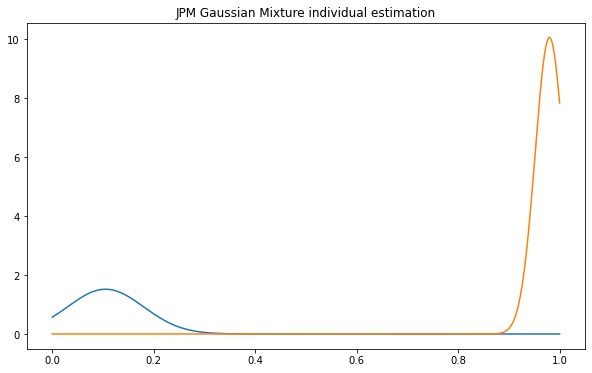

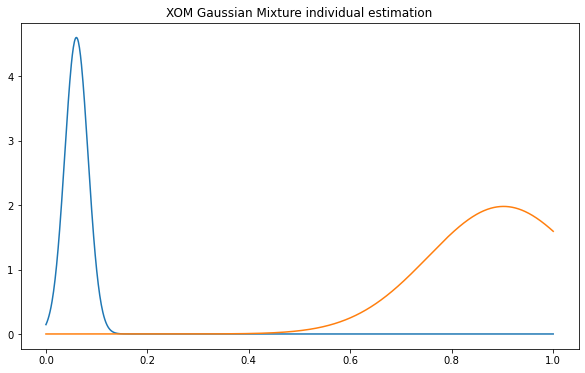

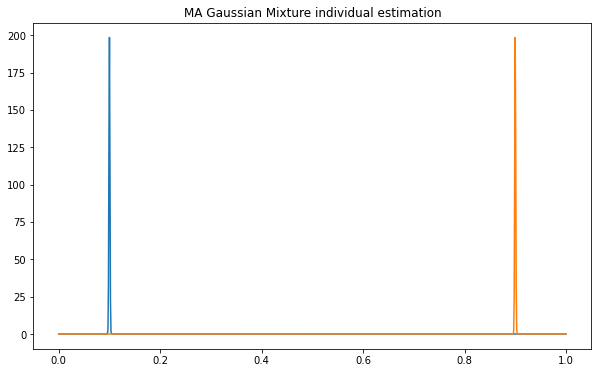

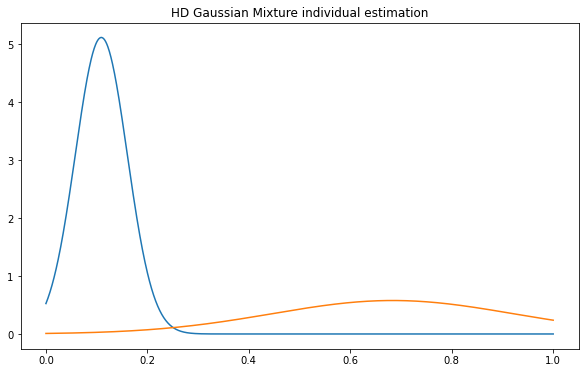

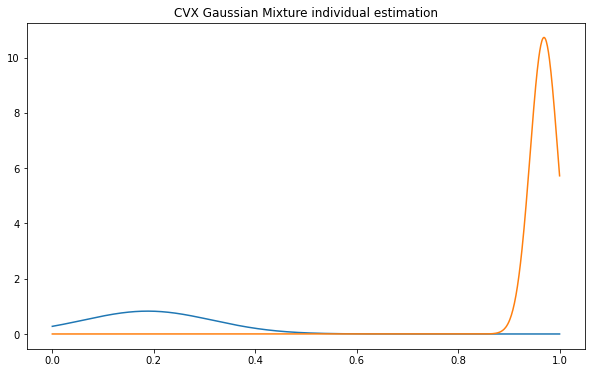

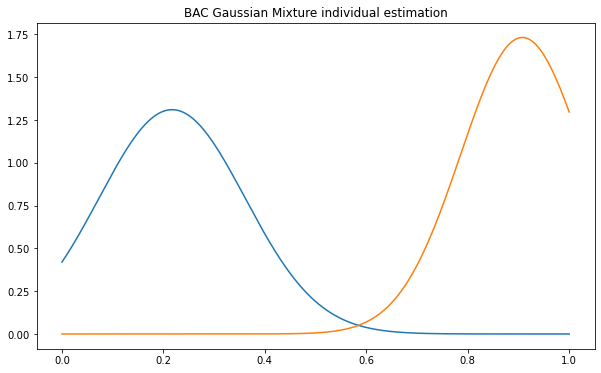

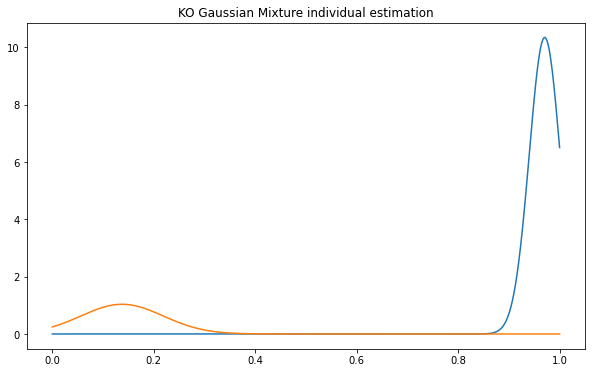

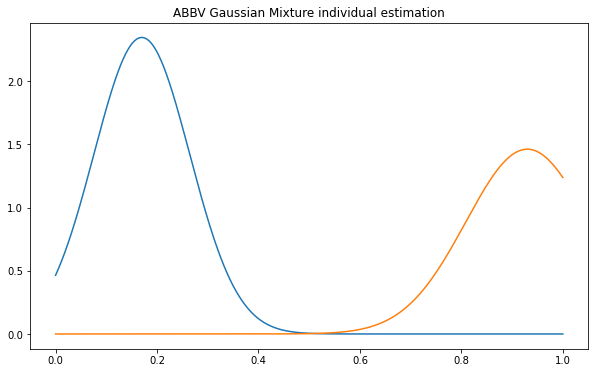

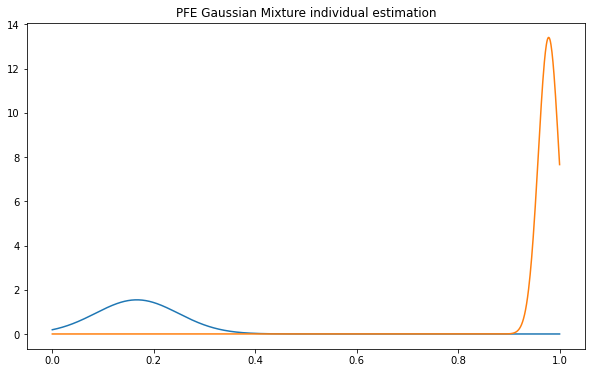

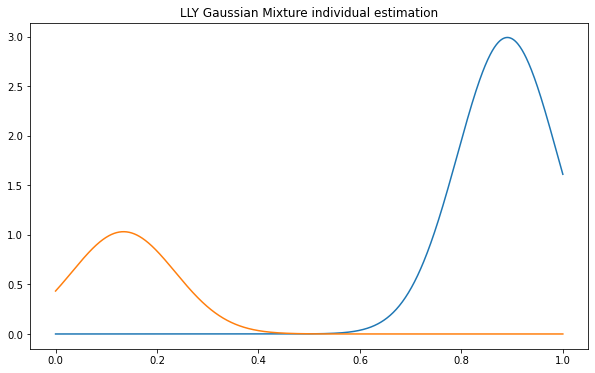

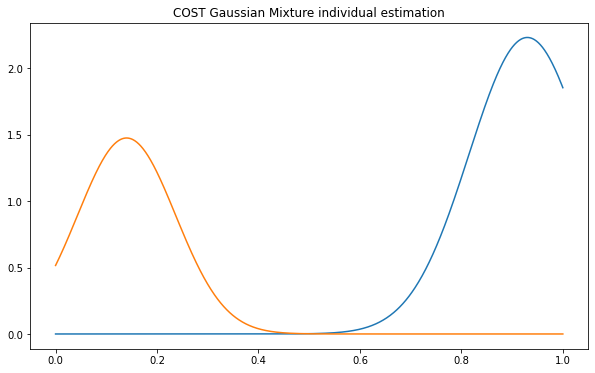

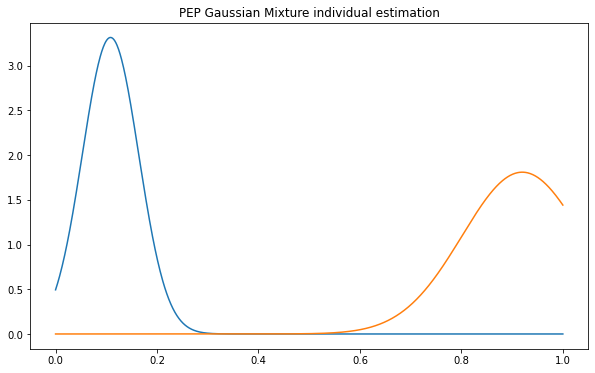

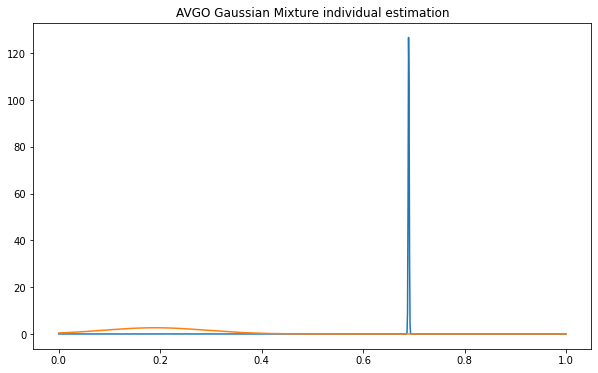

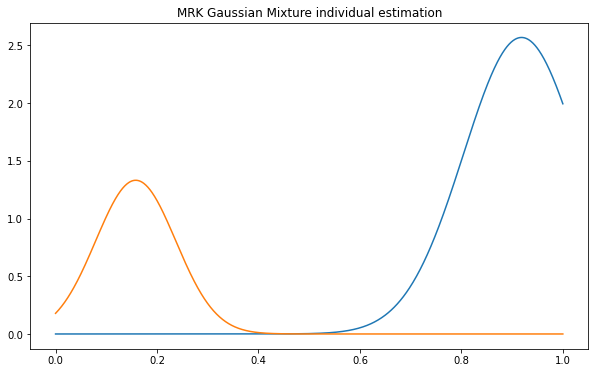

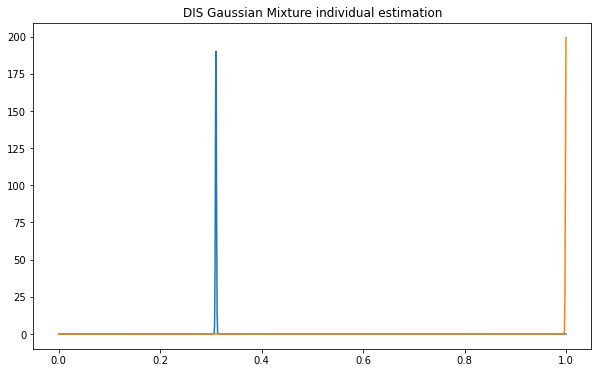

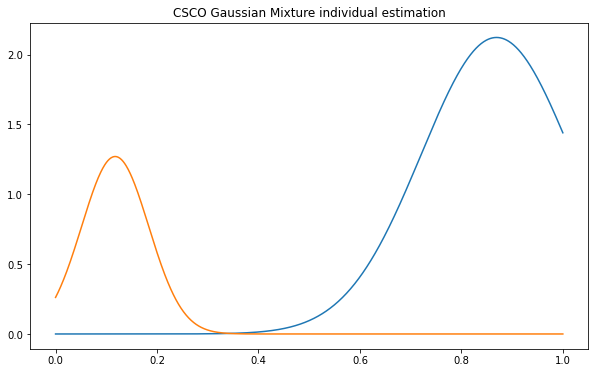

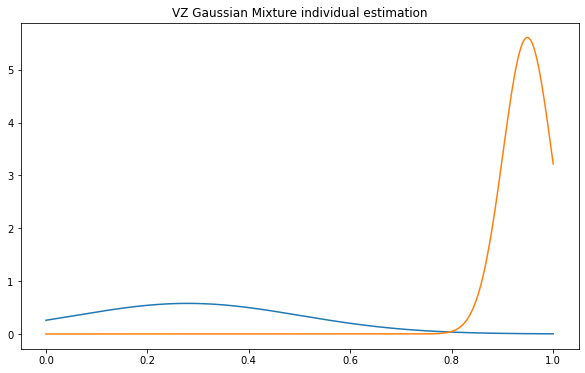

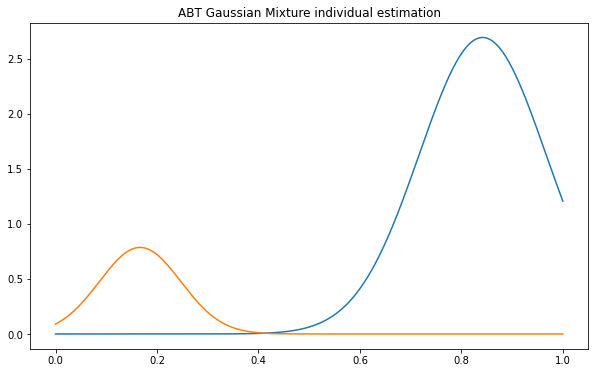

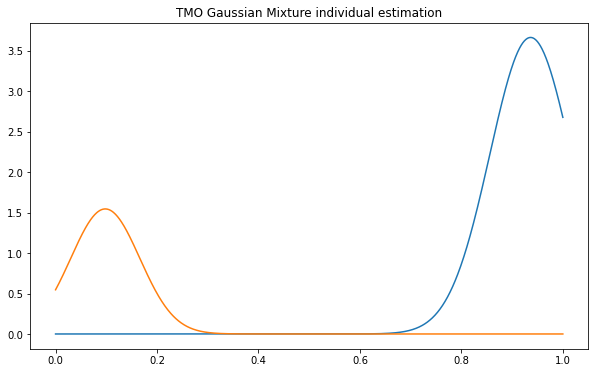

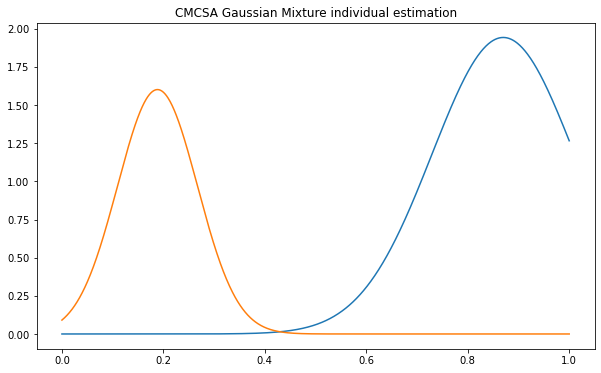

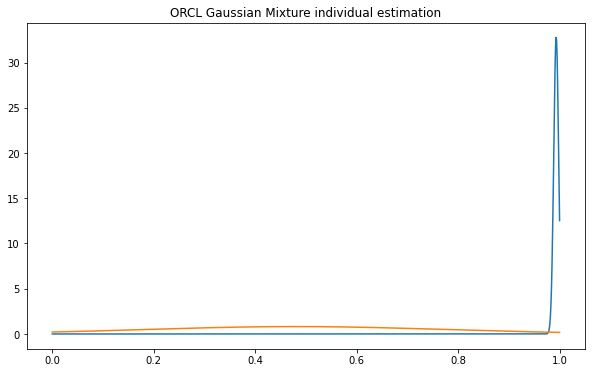

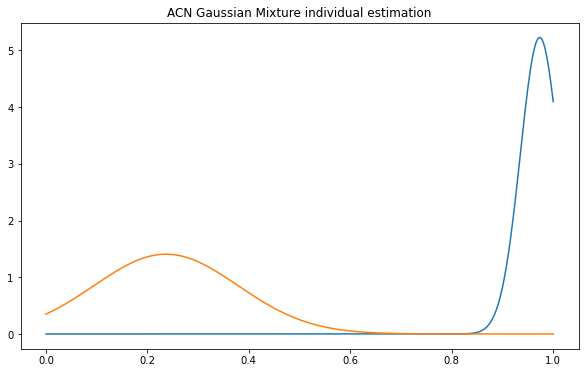

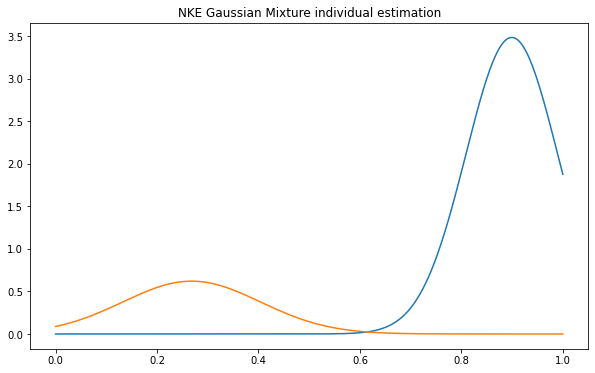

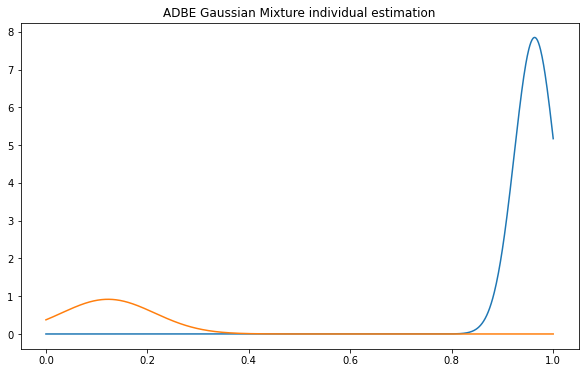

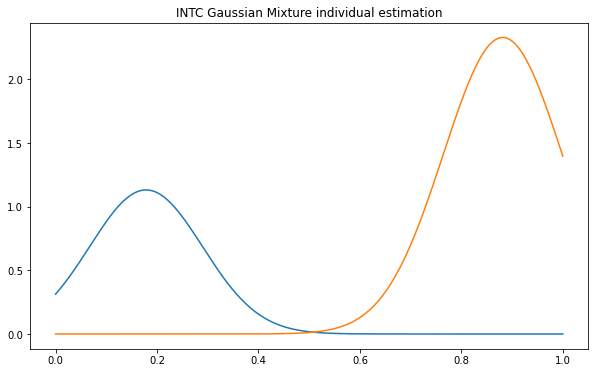

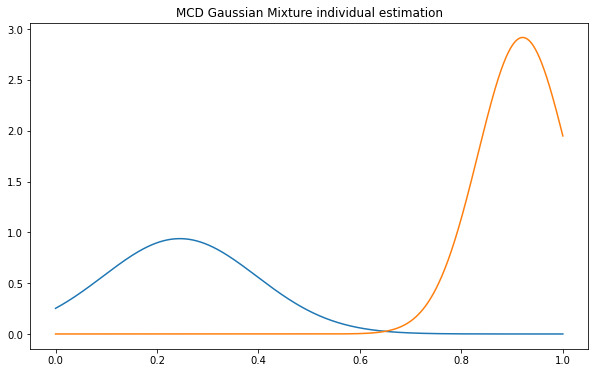

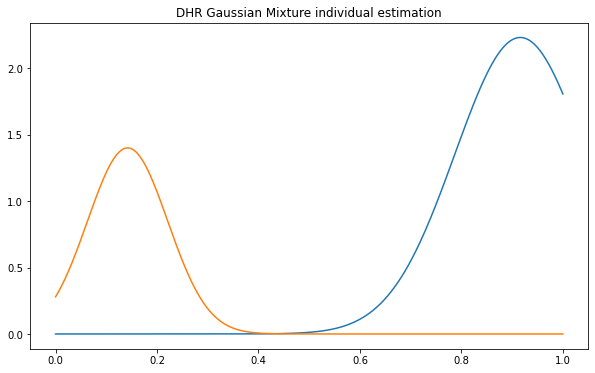

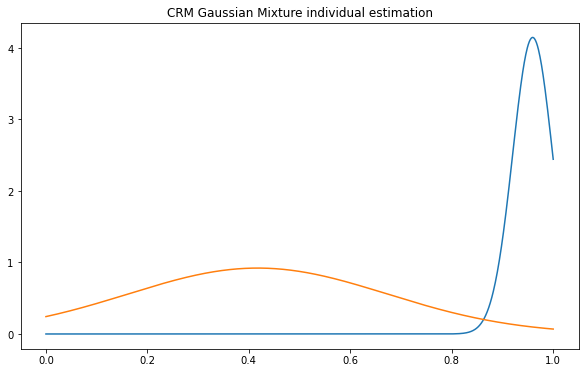

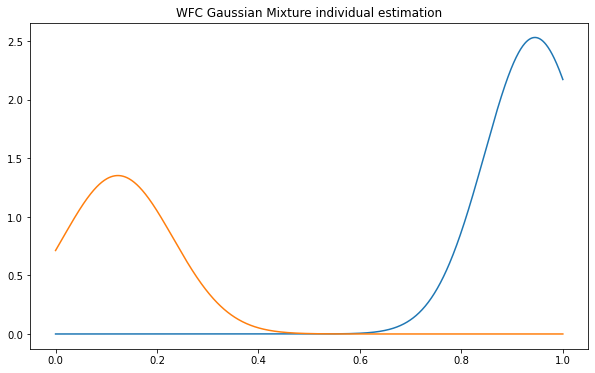

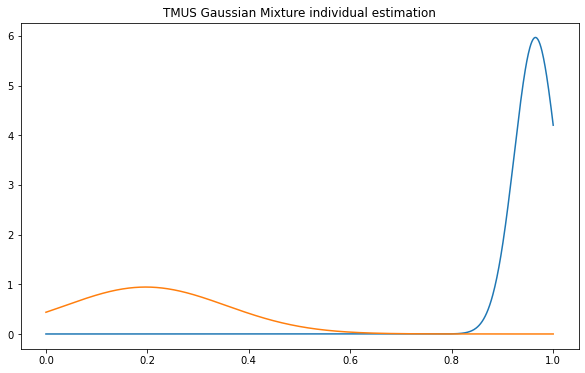

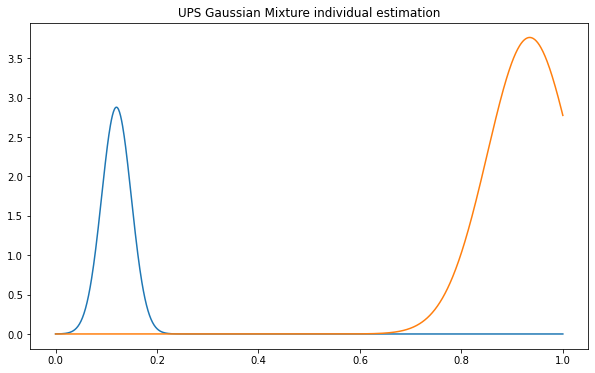

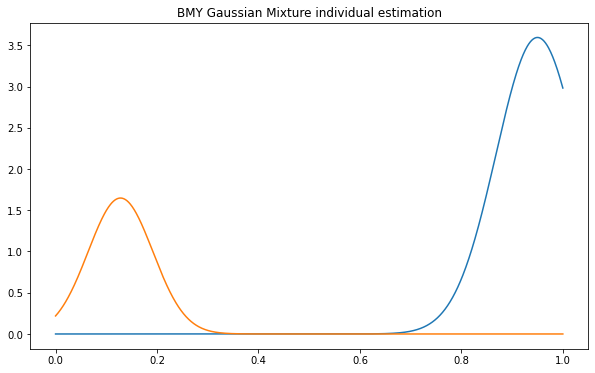

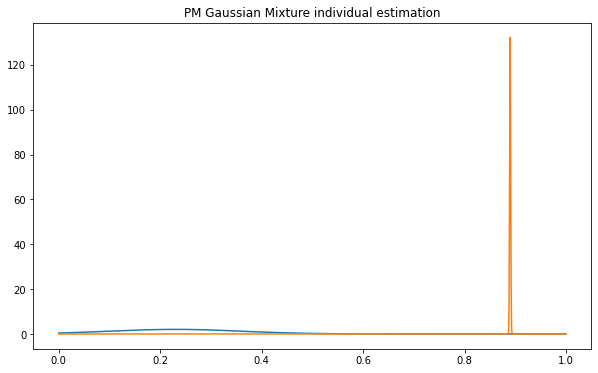

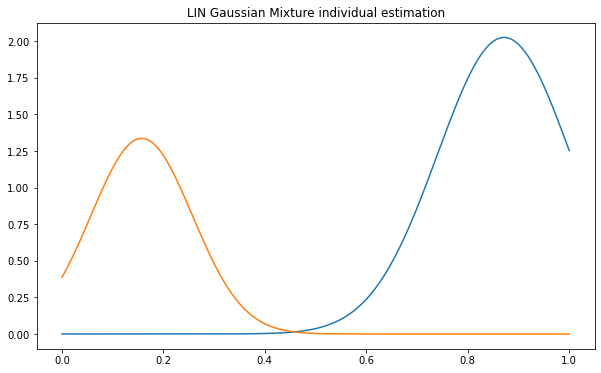

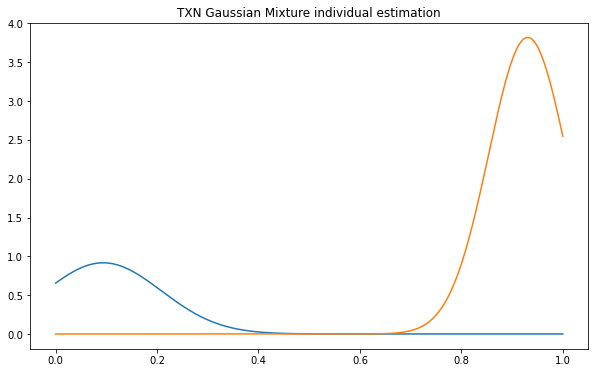

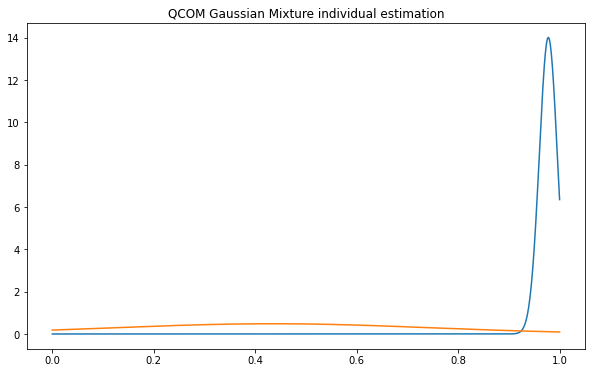

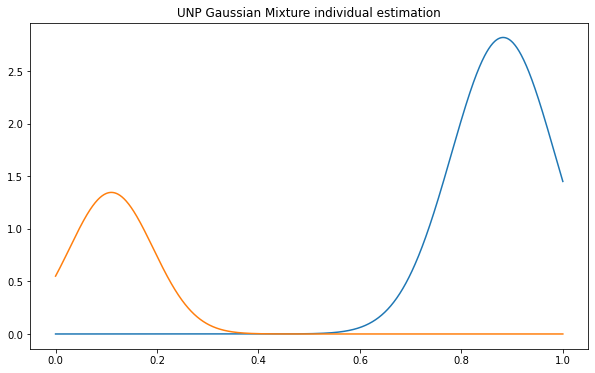

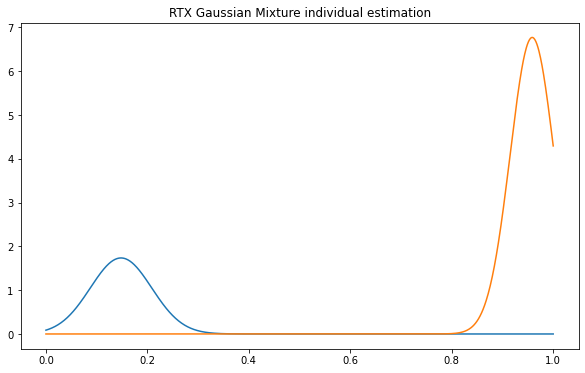

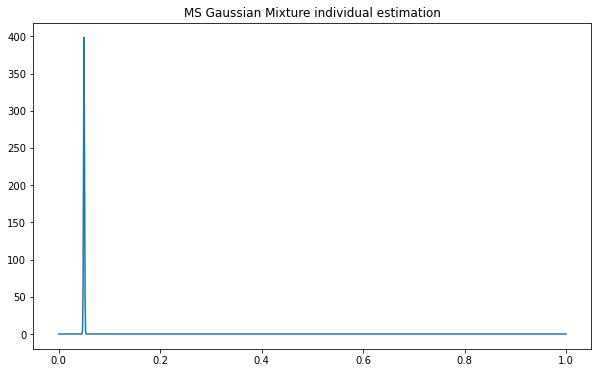

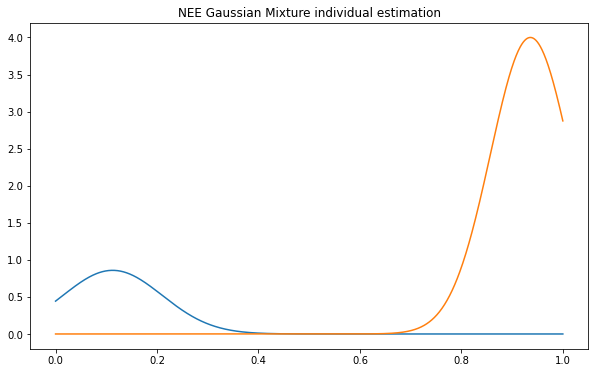

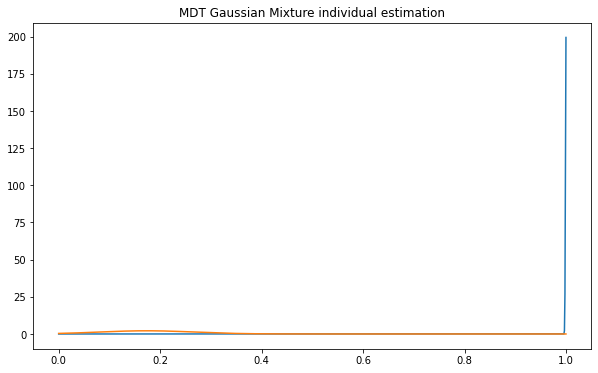

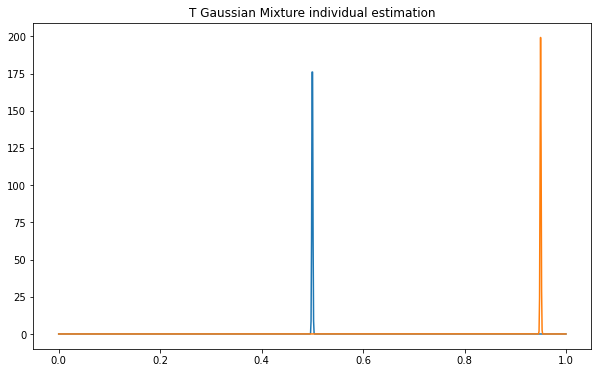

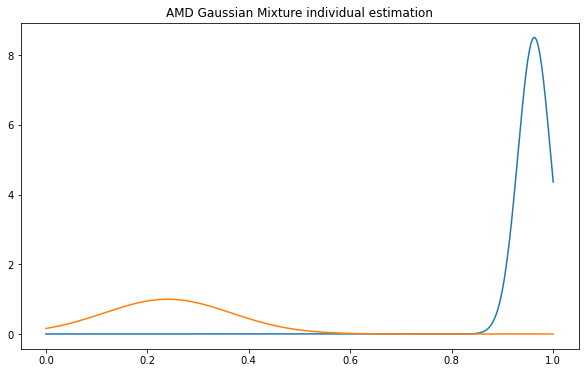

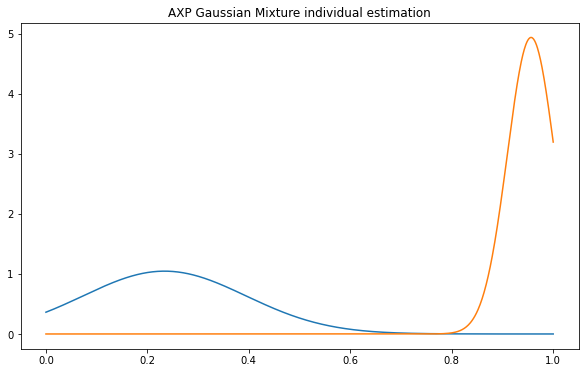

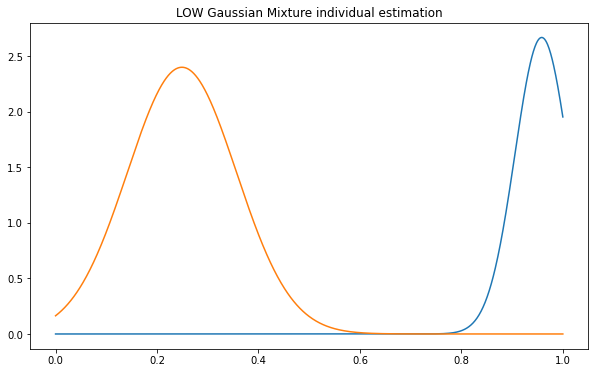

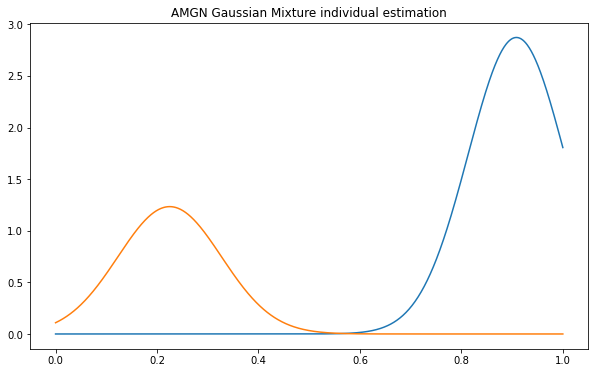

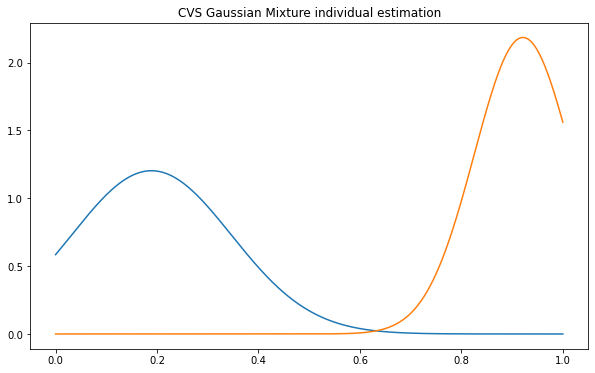

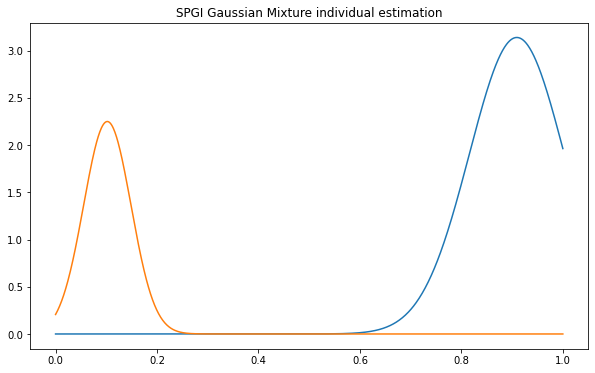

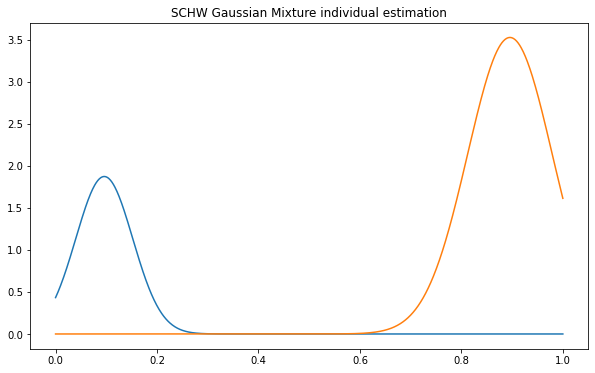

In [50]:
# Plot the Gaussian distributions
gauss_ana.plot_gaussians()

In [52]:
th_est = gauss_ana.threshold_estimation()
pd.DataFrame({'Company': th_est.keys(), 'Threshold': th_est.values()}).head()

,Company,Threshold
0,MSFT,0.805806
1,GOOG,0.953954
2,TSLA,0.963964
3,UNH,0.427427
4,JNJ,0.892893
